In [1]:
# Cell 1: Platform-Agnostic Configuration
import os
import sys

# --- Environment Detection ---
# This block detects the environment and sets the correct project path.
# You only need to modify the path for the environment you are using.
# --------------------------------------------------------------------------
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if IN_COLAB:
    print("✅ Running on Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

    # --- Colab ---
    # IMPORTANT: Change this to the path of your project folder in Google Drive
    PROJECT_PATH = '/content/drive/MyDrive/smoky-vehicle-detection'
    os.chdir(PROJECT_PATH)

elif IN_KAGGLE:
    print("✅ Running on Kaggle")
    # --- Kaggle ---
    # IMPORTANT: Change this to the path of your Kaggle dataset.
    # This path is usually /kaggle/input/<your-dataset-name>
    PROJECT_PATH = '/kaggle/input/your-dataset-name' # <-- CHANGE THIS
    os.chdir(PROJECT_PATH)

else:
    print("✅ Running on a local machine")
    # --- Local ---
    # IMPORTANT: If your notebook is in the project root, you don't need to change this.
    # Otherwise, change '.' to the full path of your project folder.
    PROJECT_PATH = '.'
    os.chdir(PROJECT_PATH)

# --- Common Setup ---
# Install required libraries (will be skipped if already installed)
!pip install -q pycocotools

# Verify that you're in the right place and your data is visible
print(f"\n✅ Current working directory: {os.getcwd()}")
print("📁 Directory contents:")
!ls

✅ Running on a local machine

✅ Current working directory: /Users/dhyeypatel/Desktop/smoky-vehicle-detection
📁 Directory contents:
__pycache__               fix_annotations.py        resize_whole
annotations               new                       smoke_detection.ipynb
check_dataset.py          new_resized               smoke_mask_rcnn_model.pth
dataset                   preprocess_images.py      train.py
dataset_resized           pytorch_smoke_env         utils.py
detect.py                 requirements.txt


In [2]:
# Cell 2: Dataset Utilities
import torch
import cv2
import numpy as np
import os
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import torchvision.transforms as T

class SmokeDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_annotations = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        img_path = os.path.join(self.root_dir, path.split('/')[-1])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(coco_annotations)
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotations[i]['bbox'][0]
            ymin = coco_annotations[i]['bbox'][1]
            xmax = xmin + coco_annotations[i]['bbox'][2]
            ymax = ymin + coco_annotations[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        masks = [self.coco.annToMask(ann) for ann in coco_annotations]
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)

        target = {"boxes": boxes, "labels": labels, "masks": masks, "image_id": torch.tensor([img_id])}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

print("Dataset and utility functions defined.")

Dataset and utility functions defined.


In [3]:
# # Cell 3: Model Training
# import torch
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# from torch.utils.data import DataLoader, random_split

# def get_model_instance_segmentation(num_classes):
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
#     return model

# # --- Configuration ---
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(f"Using device: {device}")

# num_classes = 2
# DATASET_DIR = "./dataset_resized" # Assumes you are using resized images
# ANNOTATIONS_FILE = "./annotations/annotations_fixed.json"
# NUM_EPOCHS = 30 # Set the number of epochs to train for

# # --- Data Loading ---
# dataset = SmokeDataset(root_dir=DATASET_DIR, annotation_file=ANNOTATIONS_FILE, transforms=get_transform(train=True))
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=2)
# print(f"Training on {len(train_dataset)} images, validating on {len(val_dataset)} images.")

# # --- Model and Optimizer ---
# model = get_model_instance_segmentation(num_classes)
# model.to(device)

# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# # --- Training Loop ---
# print(f"Starting training for {NUM_EPOCHS} epochs...")

# for epoch in range(NUM_EPOCHS):
#     model.train()
#     epoch_loss = 0
#     for i, (images, targets) in enumerate(train_loader):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         epoch_loss += losses.item()
#         if (i+1) % 10 == 0: # Print status every 10 iterations
#              print(f"Epoch {epoch+1}, Iteration {i+1}/{len(train_loader)}, Loss: {losses.item():.4f}")

#     lr_scheduler.step()
#     print(f"--- Epoch {epoch+1} Summary: Average Loss: {epoch_loss / len(train_loader):.4f} ---")

# # --- Save the Model ---
# torch.save(model.state_dict(), "smoke_mask_rcnn_model.pth")
# print("Training complete. Model saved to smoke_mask_rcnn_model.pth")








# Cell 3: Model Training
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader, random_split

def get_model_instance_segmentation(num_classes):
    # Initialize the model with pre-trained weights
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the box classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

# --- Configuration ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

num_classes = 2
DATASET_DIR = "./dataset_resized" # Assumes you are using resized images
ANNOTATIONS_FILE = "./annotations/annotations_fixed.json"
NUM_EPOCHS = 30 # Set the number of epochs to train for

# --- Data Loading ---
dataset = SmokeDataset(root_dir=DATASET_DIR, annotation_file=ANNOTATIONS_FILE, transforms=get_transform(train=True))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# ⭐️ CORRECTED: Set num_workers=0 to avoid multiprocessing issues in notebooks.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0)
print(f"Training on {len(train_dataset)} images, validating on {len(val_dataset)} images.")

# --- Model and Optimizer ---
model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# --- Training Loop ---
print(f"Starting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        if (i+1) % 10 == 0: # Print status every 10 iterations
             print(f"Epoch {epoch+1}, Iteration {i+1}/{len(train_loader)}, Loss: {losses.item():.4f}")

    lr_scheduler.step()
    print(f"--- Epoch {epoch+1} Summary: Average Loss: {epoch_loss / len(train_loader):.4f} ---")

# --- Save the Model ---
# Note: In Kaggle, this saves to /kaggle/working/smoke_mask_rcnn_model.pth
torch.save(model.state_dict(), "smoke_mask_rcnn_model.pth")
print("Training complete. Model saved to smoke_mask_rcnn_model.pth")

Using device: cpu
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Training on 508 images, validating on 127 images.
Starting training for 30 epochs...


KeyboardInterrupt: 

Running inference on: ./dataset_resized/image36.jpg
Detected 1 instances of smoke.


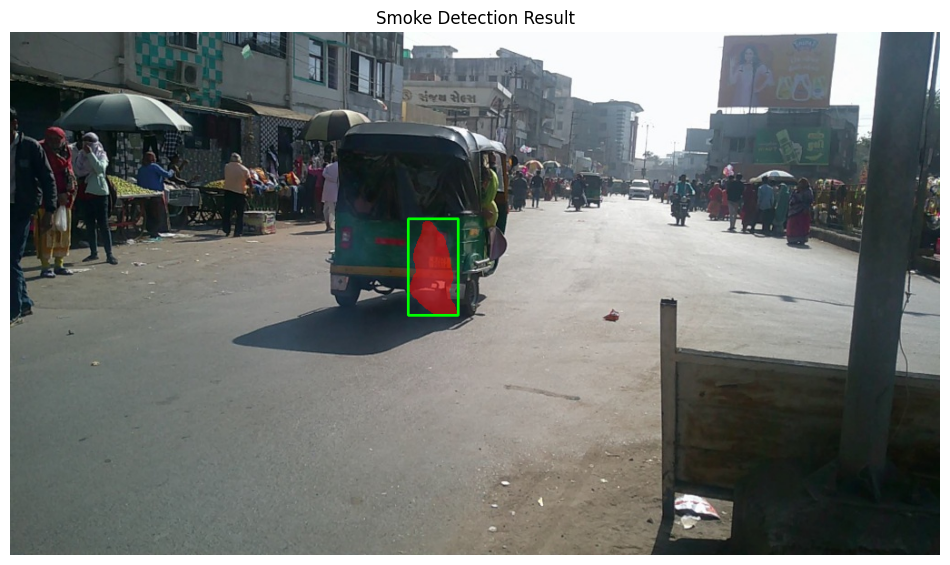

In [37]:
# Cell 4: Inference
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import cv2
import numpy as np
import os
import torchvision.transforms as T

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

# --- Configuration ---
MODEL_PATH = "smoke_mask_rcnn_model.pth"
DATASET_DIR = "./dataset_resized"
#DATASET_DIR = "./dataset"

CONFIDENCE_THRESHOLD = 0.5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2 # Define num_classes here as it's needed for get_model_instance_segmentation

# --- Load Model ---
# We need to re-define the model structure first
inference_model = get_model_instance_segmentation(num_classes)
inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
inference_model.to(device)
inference_model.eval()

# --- Select and Load a Random Image ---
image_files = [f for f in os.listdir(DATASET_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_name = random.choice(image_files)
image_path = os.path.join(DATASET_DIR, image_name)
image_path = "./img1.png"
image_path = "./test.jpeg"
image_path = "./img1161.png"
image_path = "./image544.jpg"
image_path = "./traffictest3.jpg"
image_path = "./traffictest2.jpeg"
print(f"Running inference on: {image_path}")

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img_rgb)

# --- Run Inference ---
with torch.no_grad():
    prediction = inference_model([img_tensor.to(device)])

# --- Visualize Results ---
scores = prediction[0]['scores'].cpu().numpy()
boxes = prediction[0]['boxes'].cpu().numpy()
masks = prediction[0]['masks'].cpu().numpy()
high_confidence_indices = scores > CONFIDENCE_THRESHOLD

if np.sum(high_confidence_indices) == 0:
    print("No smoke detected with high confidence.")
    plt.imshow(img_rgb)
    plt.title("No smoke detected")
    plt.axis('off')
    plt.show()
else:
    print(f"Detected {np.sum(high_confidence_indices)} instances of smoke.")
    for i, (box, mask) in enumerate(zip(boxes[high_confidence_indices], masks[high_confidence_indices])):
        mask_binary = (mask[0] > 0.5)
        color = np.array([0, 0, 255]) # Blue
        masked_img = np.where(mask_binary[..., None], color, img).astype(np.uint8)
        img = cv2.addWeighted(img, 0.5, masked_img, 0.5, 0)

        pt1 = (int(box[0]), int(box[1]))
        pt2 = (int(box[2]), int(box[3]))
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2) # Green box

    plt.figure(figsize=(12, 9))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Smoke Detection Result")
    plt.axis('off')
    plt.show()
    

Running inference on: ./traffictest3.jpeg
Detected 3 instances of smoke.


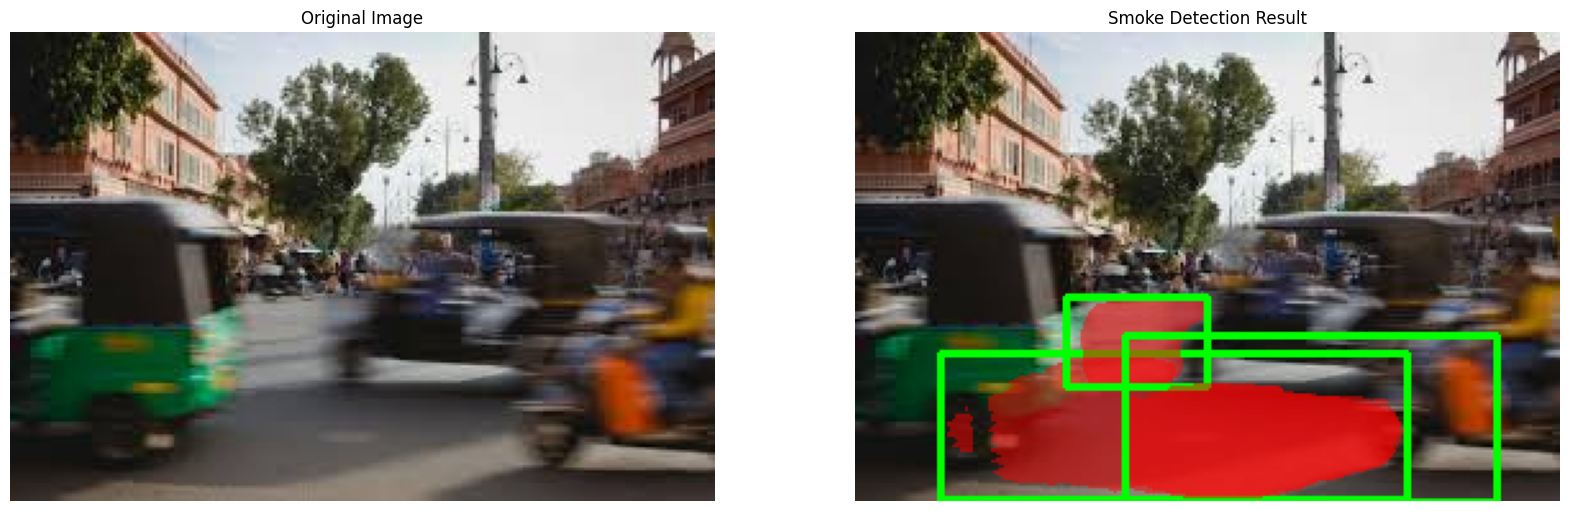

In [78]:
# Cell 4: Inference
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import cv2
import numpy as np
import os
import torchvision.transforms as T

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

# --- Configuration ---
MODEL_PATH = "smoke_mask_rcnn_model.pth"
DATASET_DIR = "./dataset_resized"
#DATASET_DIR = "./dataset"

CONFIDENCE_THRESHOLD = 0.3
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2 # Define num_classes here as it's needed for get_model_instance_segmentation

# --- Load Model ---
# We need to re-define the model structure first
inference_model = get_model_instance_segmentation(num_classes)
inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
inference_model.to(device)
inference_model.eval()

# --- Select and Load a Random Image ---
image_files = [f for f in os.listdir(DATASET_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_name = random.choice(image_files)
image_path = os.path.join(DATASET_DIR, image_name)
image_path = "./img1.png"
image_path = "./test.jpeg"
# image_path = "./img1161.png"
# image_path = "./image544.jpg"
# image_path = "./traffictest.jpg"
image_path = "./traffictest3.jpeg"
# image_path = "./smokingman.jpeg"
print(f"Running inference on: {image_path}")

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Keep a copy of the original RGB image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img_rgb)

# --- Run Inference ---
with torch.no_grad():
    prediction = inference_model([img_tensor.to(device)])

# --- Visualize Results ---
scores = prediction[0]['scores'].cpu().numpy()
boxes = prediction[0]['boxes'].cpu().numpy()
masks = prediction[0]['masks'].cpu().numpy()
high_confidence_indices = scores > CONFIDENCE_THRESHOLD

if np.sum(high_confidence_indices) == 0:
    print("No smoke detected with high confidence.")
    plt.imshow(img_rgb)
    plt.title("No smoke detected")
    plt.axis('off')
    plt.show()
else:
    print(f"Detected {np.sum(high_confidence_indices)} instances of smoke.")
    
    # Create a copy of the BGR image to draw on, leaving the original `img` intact for a moment
    detection_img = img.copy()

    for i, (box, mask) in enumerate(zip(boxes[high_confidence_indices], masks[high_confidence_indices])):
        mask_binary = (mask[0] > 0.5)
        color = np.array([0, 0, 255]) # Blue for mask
        masked_img = np.where(mask_binary[..., None], color, detection_img).astype(np.uint8)
        detection_img = cv2.addWeighted(detection_img, 0.5, masked_img, 0.5, 0)

        pt1 = (int(box[0]), int(box[1]))
        pt2 = (int(box[2]), int(box[3]))
        cv2.rectangle(detection_img, pt1, pt2, (0, 255, 0), 2) # Green box

    # *** MODIFIED PART: Setup subplots to show original and detected images ***
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10)) # Create 1 row, 2 columns of plots

    # Display original image on the left
    ax1.imshow(img_rgb)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Display image with detections on the right
    ax2.imshow(cv2.cvtColor(detection_img, cv2.COLOR_BGR2RGB))
    ax2.set_title("Smoke Detection Result")
    ax2.axis('off')

    plt.show()